# Classification with Naive Bayes

In [1]:
import random

import pandas as pd

## The watermelon dataset

In the following we use the Watermelon dataset from Zhou's textbook, where each record represents a watermelon with its features (color, sound, texture, etc) and with a boolean value indicating if the watermelon is ripe or not.
Notice:
Input features have different types: *color, root, sound, texture, umbilicus, surface* are categorical (have a finite number of nominal values that can only enumerated and compared by equality operators), while *density, sugar* are numerical (continuous) and mathematical operators can be used to transform their values.

We can easily read this CSV dataset using pandas.

In [3]:
dataset = pd.read_csv('datasets/watermelon-dataset.csv')
dataset

,ID,color,root,sound,texture,umbilicus,surface,density,sugar,ripe
0,1,green,curly,muffled,clear,hollow,hard,0.697,0.460,True
1,2,dark,curly,dull,clear,hollow,hard,0.774,0.376,True
2,3,dark,curly,muffled,clear,hollow,hard,0.634,0.264,True
3,4,green,curly,dull,clear,hollow,hard,0.608,0.318,True
4,5,light,curly,muffled,clear,hollow,hard,0.556,0.215,True
5,6,green,slightly curly,muffled,clear,slightly hollow,soft,0.403,0.237,True
6,7,dark,slightly curly,muffled,slightly blurry,slightly hollow,soft,0.481,0.149,True
7,8,dark,slightly curly,muffled,clear,slightly hollow,hard,0.437,0.211,True
8,9,dark,slightly curly,dull,slightly blurry,slightly hollow,hard,0.666,0.091,False
9,10,green,straight,crisp,clear,flat,soft,0.243,0.267,False


# Your work: what you have to do

- 1. Use `CategoricalNB` and `GaussianNB` from `scikit-learn` to build a Naive Bayes classifier on the watermelon dataset. For the estimated probabilities, consider the Laplace correction techniques.

- 2. Using the previously trained model, predict the ripe/unripe class of the test example proposed by the book:
*ID=T1, color=green, root=curly, sound=muffled, texture=clear, umbilicous=hollow, surface=hard, density=0.697, sugar=0.460. *

- 3. Giving the dataset size, consider now an hold-out technique in which you draw randomly a single test example and you train the model on the remaining examples.

- 4. Build the confusion matrix and the ROC curves for naive Bayes and decision Trees

- 5. Implement statistical tests (e.g. `ttest_rel` in [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html)) to compare model trained at 3. to a Decision Tree on the same dataset with an hold-out method. Have the observed differences in predictive performance statistical  significance?

# **Svolgimento degli esercizi**

- 1. Use `CategoricalNB` and `GaussianNB` from `scikit-learn` to build a Naive Bayes classifier on the watermelon dataset. For the estimated probabilities, consider the Laplace correction techniques.
- 2. Using the previously trained model, predict the ripe/unripe class of the test example proposed by the book: *ID=T1, color=green, root=curly, sound=muffled, texture=clear, umbilicous=hollow, surface=hard, density=0.697, sugar=0.460. *

In [76]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# ===============================
# 1. Preprocessing separo feature e target
# ===============================
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(exclude=['object']).columns

# Codifica delle categoriche
encoder = OrdinalEncoder()
X_cat = encoder.fit_transform(X[categorical_cols])

# Estraggo anche le numeriche
X_num = X[numeric_cols].to_numpy()

# Codifico il target
label_enc = LabelEncoder()
y_encoded = label_enc.fit_transform(y)

# ===============================
# 2. Training separato
# ===============================
cat_nb = CategoricalNB(alpha=1, fit_prior=False)
cat_nb.fit(X_cat, y_encoded)

gauss_nb = GaussianNB(var_smoothing=1e-9)
gauss_nb.fit(X_num, y_encoded)

test_example = pd.DataFrame({
    'color': ['green'],
    'root': ['curly'],
    'sound': ['muffled'],
    'texture': ['clear'],
    'umbilicus': ['hollow'],
    'surface': ['hard'],
    'density': [0.697],
    'sugar': [0.460]
})

test_cat = encoder.transform(test_example[categorical_cols])

print(test_cat)
cat_probs = cat_nb.predict_proba(test_cat)
num_probs = gauss_nb.predict_proba(test_example[numeric_cols].to_numpy())

# Prior delle classi (stesso ordine)
priors = cat_nb.class_log_prior_

# Combinazione logaritmica
combined_log_probs = np.log(cat_probs) + np.log(num_probs) - np.log(priors)

# Converto in probabilità normali (opzionale ?)
combined_probs = np.exp(combined_log_probs)
combined_probs /= combined_probs.sum(axis=1, keepdims=True)

# Classe finale predetta
y_pred_combined = np.argmax(combined_probs, axis=1)
predicted_class = label_enc.inverse_transform(y_pred_combined)

print("Classe predetta:", predicted_class)


[[1. 0. 2. 1. 1. 0.]]
Classe predetta: [False]


- 3. Giving the dataset size, consider now an hold-out technique in which you draw randomly a single test example and you train the model on the remaining examples.

In [81]:
from sklearn.model_selection import KFold
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.utils import shuffle
import random

#Mischio il dataframe
dataset = shuffle(dataset)

#Divido in feature e target
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(exclude=['object']).columns

#Encodo le var. categoriche
encoder = OrdinalEncoder()
X_cat = encoder.fit_transform(X[categorical_cols])

# Estraggo anche le numeriche
X_num = X[numeric_cols].to_numpy()

# Codifico il target
label_enc = LabelEncoder()
y_encoded = label_enc.fit_transform(y)

# 1/17 mi da esattamente la percentuale per avere un test example
#Splitto per categorical
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_encoded, test_size=(1/17), random_state=42)

#Splitto per gaussian
X_train_gauss, X_test_gauss, y_train_gauss, y_test_gauss = train_test_split(X_num, y_encoded, test_size=(1/17), random_state=42)


cat_nb = CategoricalNB(alpha=1, fit_prior=False)
cat_nb.fit(X_train_cat, y_train_cat)

gauss_nb = GaussianNB(var_smoothing=1e-9)
gauss_nb.fit(X_train_gauss, y_train_gauss)




GaussianNB()

- 4. Build the confusion matrix and the ROC curves for naive Bayes and decision Trees

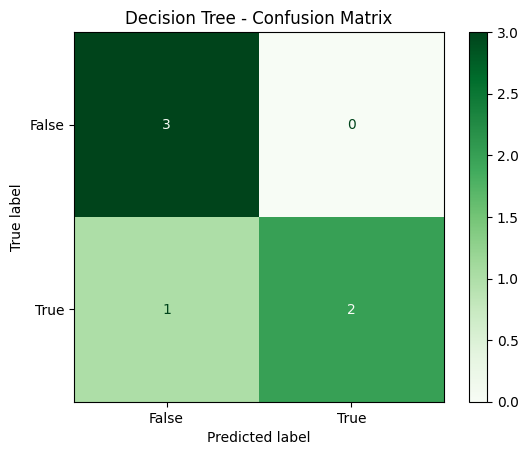

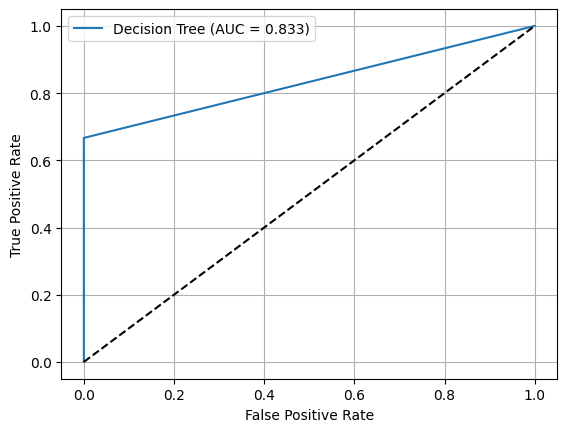

In [82]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# 1. Dividi feature e target
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]


# 2. Identifica le colonne categoriche
categorical_cols = X.select_dtypes(include=['object']).columns

# 3. Codifica solo le categoriche in numeri
encoder = OrdinalEncoder()
X[categorical_cols] = encoder.fit_transform(X[categorical_cols])

# 4. Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

dt = DecisionTreeClassifier(
    criterion="entropy",  # o "gini"
    max_depth=None,
    random_state=42
)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]  # solo per problemi binari

# Confusion matrix DecisionTree
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, cmap="Greens")
plt.title("Decision Tree - Confusion Matrix")
plt.show()

# ROC curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_dt:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# Confusion matrix NAIVE Bayes
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, cmap="Greens")
plt.title("Decision Tree - Confusion Matrix")
plt.show()

# ROC curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_dt:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()
